In [16]:
import glob
import imageio
import numpy as np
from skimage.transform import resize
pngs = glob.glob("e:/github/lin*/COVID*/data/train/*.png")
print(len(pngs))
sz,imgs=128,[]
for png in pngs[:]:
    img = imageio.imread(png)
    img = resize(img, (sz,sz))
    if len(img.shape) > 2:
        continue
    width = np.max(img) - np.min(img)
    img = img - np.min(img)
    img = img/width
    img = img.reshape((sz,sz,1))
    imgs = imgs + [img]
    if len(imgs) % 100 == 0:
        print(len(imgs))

13413
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
11400
11500
11600
11700
11800
11900
12000
12100
12200
12300
12400
12500
12600
12700
12800
12900
13000
13100
13200
13300


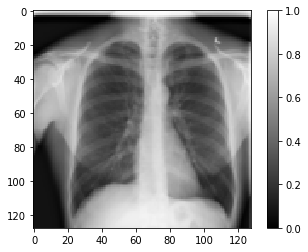

In [27]:
import matplotlib.pyplot as plt
plt.figure()
plt.imshow(imgs[7].reshape((sz,sz)), cmap=plt.cm.gray)
plt.colorbar()
plt.grid(False)
plt.show()

In [28]:
from keras.layers import Dense, Input, SpatialDropout2D
from keras.layers import Conv2D, Flatten, Lambda
from keras.layers import LocallyConnected2D, ZeroPadding2D
from keras.layers import MaxPooling2D, UpSampling2D
from keras.layers import Reshape, Conv2DTranspose
from keras.layers import ActivityRegularization
from keras.models import Model
from keras.datasets import mnist
from keras.losses import mse, binary_crossentropy
from keras.utils import plot_model
from keras import backend as K

# reparameterization trick
# instead of sampling from Q(z|X), sample eps = N(0,I)
# then z = z_mean + sqrt(var)*eps
def sampling(args):
    """Reparameterization trick by sampling fr an isotropic unit Gaussian.

    # Arguments
        args (tensor): mean and log of variance of Q(z|X)

    # Returns
        z (tensor): sampled latent vector
    """

    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean=0 and std=1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon



In [46]:
def build_autoencoder(sz, optimizer, loss):

    # create encoder side
    input_img = Input(shape=(sz,sz,1))
    x = Conv2D(16, (3,3), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2,2), padding='same')(x)
    x = SpatialDropout2D(0.1)(x)
    x = Conv2D(32, (3,3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2,2), padding='same')(x)
    x = Conv2D(32, (3,3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2,2), padding='same')(x)
    x = Conv2D(64, (3,3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2,2), padding='same')(x)
    x = LocallyConnected2D(4, (3,3))(x)
    x = ZeroPadding2D(padding=(1,1))(x)
    # x = MaxPooling2D((2,2), padding='same')(x)
    encoded_layer = ActivityRegularization(l1=0.0e-4,l2=0.0e-4)(x)

    # shape info needed to build decoder model
    shape = K.int_shape(encoded_layer)
    print(shape)

    # generate latent vector Q(z|X)
    latent_dim = 24
    x = Flatten()(encoded_layer)
    x = Dense(latent_dim, activation='relu')(x)
    z_mean = Dense(latent_dim, name='z_mean')(x)
    z_log_var = Dense(latent_dim, name='z_log_var')(x)

    # use reparameterization trick to push the sampling out as input
    # note that "output_shape" isn't necessary with the TensorFlow backend
    z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])


    encoder = Model(input_img, [z_mean, z_log_var, z], name='encoder')
    encoder.summary()
    # plot_model(encoder, to_file='data\dicom_encoder.png', show_shapes=True)

    # TODO: add threshold layer for sparsity test



    # build decoder model
    latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
    x = Dense(shape[1] * shape[2] * shape[3], activation='relu')(latent_inputs)
    x = Reshape((shape[1], shape[2], shape[3]))(x)

    x = LocallyConnected2D(4, (3,3))(x)
    x = ZeroPadding2D(padding=(1,1))(x)
    x = UpSampling2D((2,2))(x)
    x = Conv2DTranspose(64, (3,3), activation='relu', padding='same')(x)
    x = UpSampling2D((2,2))(x)
    x = Conv2DTranspose(32, (3,3), activation='relu', padding='same')(x)
    x = UpSampling2D((2,2))(x)
    x = Conv2DTranspose(32, (3,3), activation='relu', padding='same')(x)
    x = UpSampling2D((2,2))(x)
    x = Conv2DTranspose(16, (3,3), activation='relu', padding='same')(x)
    #x = UpSampling2D((2,2))(x)
    decoded_layer = Conv2D(1, (3,3), activation='sigmoid', padding='same')(x)
    decoder = Model(latent_inputs, decoded_layer)
    decoder.summary()
    # plot_model(decoder, to_file='data\dicom_decoder.png', show_shapes=True)

    autoencoder_output = decoder(encoder(input_img)[2])
    autoencoder = Model(input_img, autoencoder_output, name='ae')
    autoencoder.compile(optimizer=optimizer, loss=loss)
    autoencoder.summary()
    # plot_model(autoencoder, to_file='data\dicom_autoencoder.png', show_shapes=True)

    return autoencoder, encoder, decoder


In [47]:
autoencoder, encode_only, decode_only = build_autoencoder(sz, 'adadelta', 
    # 'binary_crossentropy')
    'mean_squared_error')

(None, 8, 8, 4)
Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, 128, 128, 1)  0                                            
__________________________________________________________________________________________________
conv2d_26 (Conv2D)              (None, 128, 128, 16) 160         input_6[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_21 (MaxPooling2D) (None, 64, 64, 16)   0           conv2d_26[0][0]                  
__________________________________________________________________________________________________
spatial_dropout2d_6 (SpatialDro (None, 64, 64, 16)   0           max_pooling2d_21[0][0]           
____________________________________________________________________________

In [48]:
import numpy as np
test_count = int(len(imgs)/10)
x_test = imgs[:test_count]
x_train = imgs[test_count:]
x_train, x_test = np.array(x_train), np.array(x_test)
print(x_train.shape, x_test.shape)

(12051, 128, 128, 1) (1338, 128, 128, 1)


In [53]:
autoencoder.fit(x_train, x_train, 
                epochs=675, batch_size=128, 
                shuffle=True, validation_data=(x_test[:32],x_test[:32]))

 - val_loss: 0.0059
Epoch 491/675
12051/12051 [==============================] - 15s 1ms/step - loss: 0.0063 - val_loss: 0.0064
Epoch 492/675
12051/12051 [==============================] - 15s 1ms/step - loss: 0.0062 - val_loss: 0.0058
Epoch 493/675
12051/12051 [==============================] - 15s 1ms/step - loss: 0.0062 - val_loss: 0.0068
Epoch 494/675
12051/12051 [==============================] - 15s 1ms/step - loss: 0.0062 - val_loss: 0.0058
Epoch 495/675
12051/12051 [==============================] - 15s 1ms/step - loss: 0.0062 - val_loss: 0.0074
Epoch 496/675
12051/12051 [==============================] - 15s 1ms/step - loss: 0.0063 - val_loss: 0.0065
Epoch 497/675
12051/12051 [==============================] - 15s 1ms/step - loss: 0.0061 - val_loss: 0.0057
Epoch 498/675
12051/12051 [==============================] - 15s 1ms/step - loss: 0.0062 - val_loss: 0.0069
Epoch 499/675
12051/12051 [==============================] - 15s 1ms/step - loss: 0.0062 - val_loss: 0.0059
Epoch 50

In [54]:
encode_only_imgs = encode_only.predict(x_test[:10])
for n in range(10):
    print("shape of encoded = ", encode_only_imgs[2].shape)
    hist, bins = np.histogram(encode_only_imgs[2])
    print(hist)
    print(bins)

shape of encoded =  (10, 24)
[ 1  0  5 14 24 58 65 47 19  7]
[-23.572866   -19.68024    -15.787617   -11.894992    -8.002367
  -4.1097417   -0.21711674   3.6755083    7.5681334   11.460758
  15.353383  ]
shape of encoded =  (10, 24)
[ 1  0  5 14 24 58 65 47 19  7]
[-23.572866   -19.68024    -15.787617   -11.894992    -8.002367
  -4.1097417   -0.21711674   3.6755083    7.5681334   11.460758
  15.353383  ]
shape of encoded =  (10, 24)
[ 1  0  5 14 24 58 65 47 19  7]
[-23.572866   -19.68024    -15.787617   -11.894992    -8.002367
  -4.1097417   -0.21711674   3.6755083    7.5681334   11.460758
  15.353383  ]
shape of encoded =  (10, 24)
[ 1  0  5 14 24 58 65 47 19  7]
[-23.572866   -19.68024    -15.787617   -11.894992    -8.002367
  -4.1097417   -0.21711674   3.6755083    7.5681334   11.460758
  15.353383  ]
shape of encoded =  (10, 24)
[ 1  0  5 14 24 58 65 47 19  7]
[-23.572866   -19.68024    -15.787617   -11.894992    -8.002367
  -4.1097417   -0.21711674   3.6755083    7.5681334   11.46

In [55]:
def show_grayscale(rows, columns, at, pixel_array, sz):
    import scipy
    ax = plt.subplot(rows, columns, at)
    interp_array = scipy.ndimage.zoom(pixel_array.reshape(sz,sz), 4.0, order=5)
    plt.imshow(interp_array.reshape(sz*4, sz*4))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

def show_original_decoded(original, decoded, sz):
    n = 10  # how many digits we will display
    plt.figure(figsize=(n*2, 4))
    for i in range(n):
        show_grayscale(2, n, i+1, original[i], sz)
        show_grayscale(2, n, i+1+n, decoded[i], sz)
    plt.show(block=True)

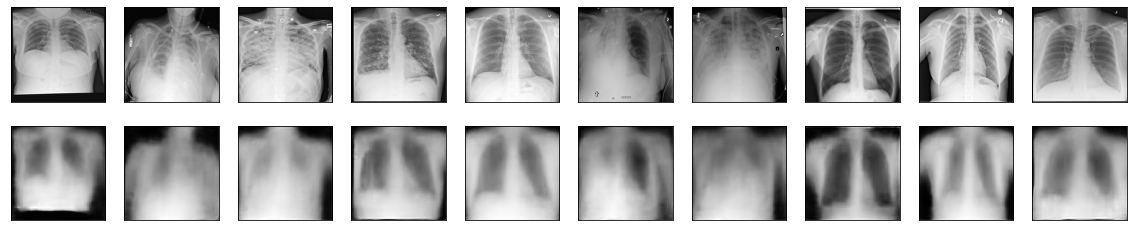

In [56]:
decoded_imgs = decode_only.predict(encode_only_imgs[2])
show_original_decoded(x_test, decoded_imgs, sz)